## Artificial Neural Network (ANN) test
In this notebook, we will explore the use of an ANN to predict impact of sensory inputs onto endocrine outputs. 

To run this notebook you need the following dependencies:
- `pandas`
- `numpy`
- `pymaid`
- `seaborn`

In [1]:
import pandas as pd
import numpy as np

import pymaid
#from connect_catmaid import *
pymaid.set_pbars(jupyter=False)

#type catmaid cedentials here:
rm = pymaid.CatmaidInstance('https://neurocean.janelia.org/catmaidL1','name','password','token')
rm.max_threads=10

import matplotlib.pyplot as plt

import seaborn as sns

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [2]:
class ANN:
    """ Simple Artificial Neural Network without backpropagation.
    
    Parameters
    ----------
    adj :           pandas.DataFrame
                    Symmetrical (MxM) adjacency matrix.
    input, output : list
                    Inputs and outputs of the network as labelled in columns/index of `adj`
    """
    
    def __init__(self, adj, inputs, outputs):
        self.adj = adj
        self.inputs = inputs
        self.outputs = outputs
        self.inter = [l for l in self.adj if l not in np.concatenate((inputs, outputs))]
        
    @property
    def adj(self):
        return self._adj
    
    @adj.setter
    def adj(self, value):
        if not isinstance(value, pd.DataFrame):
            raise TypeError('Must be DataFrame, not "{}"'.format(type(value)))
        if value.shape[0] != value.shape[1]:
            raise ValueError('Adjacency matrix must be symmetrical')
        if any(value.columns != value.index):
            raise ValueError('Columns must match index names')
        self._adj = value
        
    def invert_weights(self, neurons):
        """ Inverts weights of given neurons (skeleton IDs)."""
        self.adj.loc[neurons] *= -1
        
    def copy(self):
        """ Returns copy of self. """
        return ANN(self.adj.copy(), self.inputs, self.outputs)
        
    def simulate(self, X, 
                 act_func,# = ANN.sigmoidal,
                 inp_out=True,
                 int_out=True, int_int=True, inp_inp=False, **kwargs):
        """ This simulates our network.
        
        Parameters
        -----------
        X :         numpy.array
                    Activity (0-1) of inputs.
        act_func :  Callable
                    Activation function to transform inputs. Must accept numpy array. Two functions
                    are built-in: `ANN.sigmoidal` and `ANN.relu`.
        inp_out :   bool, optional
                    If True will include direct connections from inputs to outputs in simulation.
        int_out :   bool, optional
                    If True will include connections from interneurons to outputs in simulation.
        int_int :   bool, optional
                    If True will include connections between interneurons in simulation. 
                    Please note that this simple feed-forward model does only simulate a single
                    layer of inter-interneuron connections.
        inp_inp :   bool, optional
                    If True will include connections between inputs. Same restrictions as int_int
                    apply.
        **kwargs :
                    Keyword arguments passed to `act_func`
                    
        Returns
        -------
        pandas.Series
                    DataTable with predicated activity of outputs.                
        """
        
        if not callable(act_func):
            raise TypeError('act_func must be Callable')
        
        # First: inputs->inputs
        if inp_inp:
            # Get weights
            self.W0 = self.adj.loc[self.inputs, self.inputs].values
            # Propagate weights
            self.z0 = np.dot(self.W0.T, X)
            # Apply activation function
            self.z0 = act_func(self.z0, **kwargs)
        else:
            self.z0 = X
        
        # Second: inputs->inter
        # Get weights
        self.W1 = self.adj.loc[self.inputs, self.inter].values
        # Propagate weights
        self.z1 = np.dot(self.W1.T, self.z0)
        # Apply activation function
        self.z1 = act_func(self.z1, **kwargs)
        
        # Third: inter->inter
        if int_int:
            # Get weights
            self.W2 = self.adj.loc[self.inter, self.inter].values
            # Propagate weights
            self.z2 = np.dot(self.W2.T, self.z1)
            # Apply activation function to the sum of original activity (z1)
            # and the one generated from inter-inter connections (z2)
            self.z2 = act_func(self.z2 + self.z1, **kwargs)
        else:
            self.z2 = self.z1
        
        # Last: input->output and inter->output
        # Get weights
        self.W3 = self.adj.loc[self.inputs, self.outputs].values
        self.W4 = self.adj.loc[self.inter, self.outputs].values
        # Propagate weights
        if inp_out and int_out:
            self.z3 = np.dot(self.W3.T, X) + np.dot(self.W4.T, self.z2)
        elif inp_out:
            self.z3 = np.dot(self.W3.T, X)
        elif int_out:
            self.z3 = np.dot(self.W4.T, self.z2)
        else:
            raise ValueError('No connections to outputs.')
            
        # Apply activation function
        self.z3 = act_func(self.z3, **kwargs)
        
        return pd.Series(self.z3, index=self.outputs)        
        
    @classmethod
    def sigmoidal(self, z, k=50, z0=.1):
        """ Sigmoidal activation function. Returns values 0-1 for inputs 0-1."""        
        # k controls steepness        
        # z0 controls half-activation point
        
        return 1 / (1 + np.exp(-k * (z - z0)))
    
    @classmethod
    def relu(self, z, resp_min=.05, resp_max=.5):
        """ Relu (rectifying linear unit) activation function."""        
        # resp_min determines at what input value the neuron starts to respond      
        # resp_max determines at what input value the neuron plateaus at max activity        

        x = z.copy()
        
        x[x < resp_min] = 0
        x[x >= resp_max] = 1
        x[(x >= resp_min) & (x < resp_max)] = (x[(x >= resp_min) & (x < resp_max)] - resp_min) / (resp_max - resp_min)
        
        return x

### Activation functions
Let's first explore the two activation functions:

Given a adjacency matrix normalised by the number of total synaptic inputs to a neuron, the activation function predicts that a neuron starts responding if ~5% of its inputs are active and will saturate at ~50% of inputs active.

#### Sigmoidal

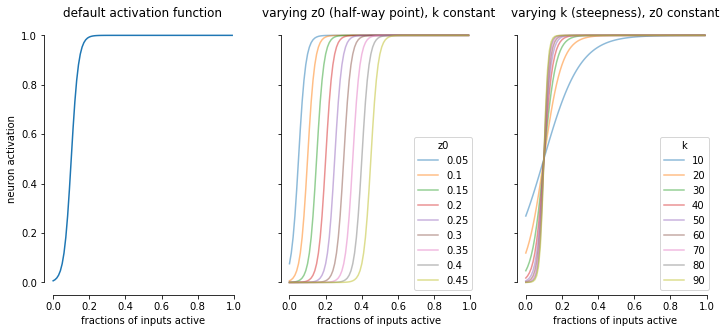

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(12,5 ), sharey=True, sharex=True)

x = np.arange(0, 1, .01)

axes[0].plot(x, ANN.sigmoidal(x))
axes[0].set_ylabel('neuron activation')
axes[0].set_xlabel('fractions of inputs active')
axes[0].set_title('default activation function')

for z0 in np.arange(.05, .5, .05):    
    axes[1].plot(x, ANN.sigmoidal(x, z0=z0), label='{}'.format(round(z0, 3)), alpha=.5)
    
axes[1].set_xlabel('fractions of inputs active')
axes[1].legend(title='z0')
axes[1].set_title('varying z0 (half-way point), k constant')

for k in np.arange(10, 100, 10):    
    axes[2].plot(x, ANN.sigmoidal(x, k=k), label='{}'.format(round(k)), alpha=.5)
    
axes[2].set_xlabel('fractions of inputs active')
axes[2].legend(title='k')
axes[2].set_title('varying k (steepness), z0 constant')

sns.despine(trim=True)

#### ReLu function


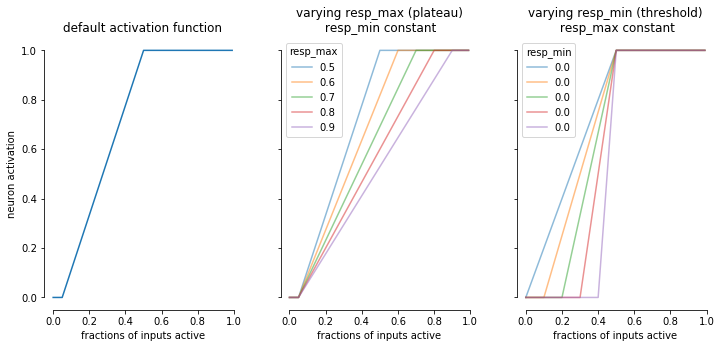

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(12,5 ), sharey=True, sharex=True)

x = np.arange(0, 1, .01)

axes[0].plot(x, ANN.relu(x))
axes[0].set_ylabel('neuron activation')
axes[0].set_xlabel('fractions of inputs active')
axes[0].set_title('default activation function')

for resp_max in np.arange(.5, 1, .1):    
    axes[1].plot(x, ANN.relu(x, resp_max=resp_max), label='{}'.format(round(resp_max, 3)), alpha=.5)
    
axes[1].set_xlabel('fractions of inputs active')
axes[1].legend(title='resp_max')
axes[1].set_title('varying resp_max (plateau)\n resp_min constant')

for resp_min in np.arange(0, .5, .1):    
    axes[2].plot(x, ANN.relu(x, resp_min=resp_min), label='{}'.format(round(resp_min)), alpha=.5)
    
axes[2].set_xlabel('fractions of inputs active')
axes[2].legend(title='resp_min')
axes[2].set_title('varying resp_min (threshold)\n resp_max constant')

sns.despine(trim=True)
plt.savefig('relu function_parameters_1-50.svg')

Let's collect the neurons for our network

In [5]:
output_an = ['IPCs', 'DMS', 'DH44', 'CRZ', 'ITP', 'PTTH', 'CALP', 'Hugin RG', 'CAPA', 'EH']
# Note here that there is something funny going on with the "(" and ")" in "TD_CO2 (potentially)":
# they count as regex so we have to escape them by adding backslashes '\'
input_an = ['enteric sensory', 'all pharyngeal sensory', 'all external sensory', 'TD_CO2',
             'AN-ORNs', 'thermosensory', 'RGpaper_somatosensory' 
            ] 
#input_an = ['AN-ORNs']
inter_an = ['RGPN_inputs_paired_unpaired_T3']
#inter_an = ['RGPN_inputs_T3_paired_sens']

# First get the neurons by annotation
outputs = pymaid.find_neurons(annotations=output_an)
inputs = pymaid.find_neurons(annotations=input_an)
inter = pymaid.find_neurons(annotations=inter_an)

# Get their skeleton data too - for normalising the adjancency matrix
outputs.get_skeletons()
inputs.get_skeletons()
inter.get_skeletons()

# Get their annotations
outputs.get_annotations()
inputs.get_annotations()
inter.get_annotations()

INFO  : Found 56 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 495 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 211 neurons matching the search parameters (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


In [6]:
# Make one big list of our neurons and remove any duplicates
all_neurons = inputs + outputs + inter
all_neurons.remove_duplicates(inplace=True)

In [7]:
# Generate big adjacency matrix
adj = pymaid.adjacency_matrix(all_neurons)

In [8]:
# Normalise matrix by total number of postsynapses of each neuruon
adj_norm = adj / np.array([all_neurons.skid[n].n_postsynapses for n in adj.columns])
adj_norm.fillna(0, inplace=True)

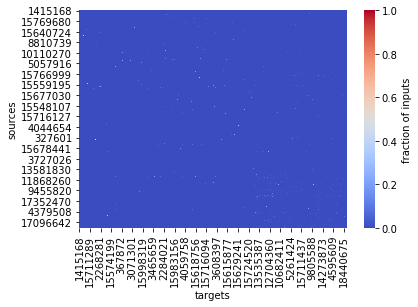

In [9]:
# Plot heatmap
ax = sns.heatmap(adj_norm, cmap='coolwarm', cbar_kws={'label': 'fraction of inputs'})

Note that "red" (=100% of their inputs) spots in above heatmap are likely sensory neurons that receive a single input from another neuron.

**Important**: because `input<->input` connections can make up a large *fraction* of their inputs despite very low absolute synapse count, it's probably not a good idea to include them in any simulation.

### Time to take her out for a spin!
Now we have everything to start up our network simulation:

In [10]:
# Initialise the network
nn = ANN(adj_norm, inputs.skeleton_id.astype(int), outputs.skeleton_id.astype(int))

Let's run a quick test with activating all **CO2 neurons** using the default settings (i.e. everything but `input<->input` connections)

In [14]:
# Generate inputs (set everything to zero for starters)
input_activity = pd.Series(np.zeros(len(nn.inputs)), index=nn.inputs)
# Current input activity at 0.6 (change value for different activation strength)
input_activity.loc[inputs.has_annotation('TD_CO2').skeleton_id.astype(int)] = 0.6

# Run simulation
res = nn.simulate(input_activity, act_func = ANN.sigmoidal)
res.head()

4188290    0.025955
5601924    0.454993
4506509    0.506034
3926669    0.853648
5955853    0.014762
dtype: float64

Write a small function to visualise results:

In [12]:
def plot_results(res):
    if isinstance(res, pd.Series):
        res = res.to_frame('activity')
    # Map "type" onto neurons
    res['type'] = res.index.map(lambda x: [a for a in output_an if a in all_neurons.skid[x].annotations][0])
    
    ax = sns.barplot(data=res, x='type', y='activity', palette='muted')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylim(0,1)
    sns.despine(trim=True)
    return ax

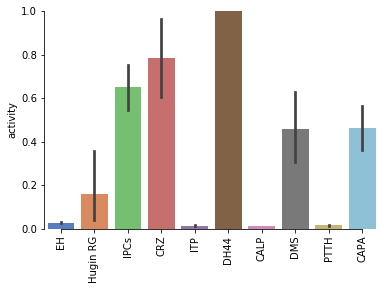

In [13]:
ax = plot_results(res)

Let's try the same with a relu activation function (note that we give a stronger input here):

In [15]:
# Generate inputs (set everything to zero for starters)
input_activity = pd.Series(np.zeros(len(nn.inputs)), index=nn.inputs)
# Set all CO2 neurons to 4 strength
input_activity.loc[inputs.has_annotation('TD_CO2').skeleton_id.astype(int)] = 4

# Run simulation
res2 = nn.simulate(input_activity, act_func=ANN.relu)
res2.head()

4188290    0.000000
5601924    0.206119
4506509    0.077490
3926669    0.140073
5955853    0.000000
dtype: float64

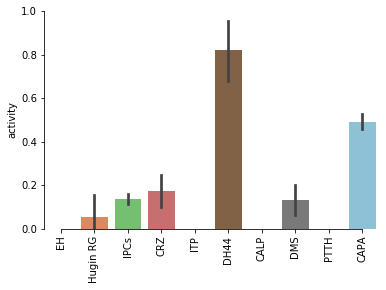

In [16]:
ax = plot_results(res2)
#plt.savefig('/Users/HueckyLAB/Documents/RING GLAND PAPER 191219/0_RGpaper_new_concept_311019/Fig_8_supp1_ANN varying parameters/ReLu/CO2_bar_act2_onlyintersens.svg')

 

### Let's run some more extensive testing by activating all input groups in turn while varying their activity levels:

In [17]:
def test_activation(nn, ingroups, outgroups, activation=[.1, .25, .5, .75, 1], **kwargs):
    """ Test the effect of activation of a set of inputs groups on a set of output groups.
    
    Parameters
    ----------
    nn :         ANN
                 The artificial neural network to test.
    ingroups :   dict
                 Map of input group -> skeleton IDs: {'inputs1': [12345, 67890], 'inputs2': [...]}
    outgroups :  dict
                 Map of outputs group -> skeleton IDs: {'outputs1': [12345, 67890], 'outputs2': [...]}
    activation : list, optional
                 Range of activation factors used (0-1): [0.1, 0.2, 0.3, 0.4, 0.5]
    kwargs
                 Keyword arguments passed to ANN.simulate()
                
    Returns
    -------
    pd.DataFrame
    """
    
    data = []
    # Go over the range of activitys
    for a in activation:
        # Iterate over ingroups
        for iname, iskids in ingroups.items():
            input_activity = pd.Series(np.zeros(len(nn.inputs)), index=nn.inputs)
            input_activity.loc[iskids] = a
            res = nn.simulate(input_activity, **kwargs)

            # Read results
            for oname, oskids in outgroups.items():
                data += [[iname, a, oname, o, res.loc[o]] for o in oskids]
    
    return pd.DataFrame(data, columns=['inputs_active', 'activation_factor', 'output_group', 'skid', 'activity'])

Generate in- and outgroups for above function

In [18]:
output_an = ['IPCs', 'DMS', 'DH44', 'CRZ', 'ITP', 'PTTH', 'CALP', 'Hugin RG', 'CAPA', 'EH']
# Note here that there is something funny going on with the "(" and ")" in "TD_CO2 (potentially)":
# they count as regex so we have to escape them by adding backslashes '\'
input_an = ['enteric sensory', 'all pharyngeal sensory', 'all external sensory', 
            'TD_CO2',
             'AN-ORNs', 'thermosensory', 'RGpaper_somatosensory' 
            ] 
#input_an = ['AN-ORNs']
inter_an = ['RGPN_inputs_paired_unpaired_T3']
#inter_an = ['RGPN_inputs_T3_paired_sens']

outgroups = {an: all_neurons.has_annotation(an, raise_not_found=False).skeleton_id.astype(int) for an in output_an}
ingroups = {an: all_neurons.has_annotation(an, raise_not_found=False).skeleton_id.astype(int) for an in input_an}

# Remove empty groups
outgroups = {g: skids for g, skids in outgroups.items() if any(skids)}
ingroups = {g: skids for g, skids in ingroups.items() if any(skids)}

OK, all set - now we can run our little test

In [19]:
activation_test_sigmoidal = test_activation(nn, ingroups, outgroups, activation=np.arange(0.1, 1.1, .1), act_func = ANN.sigmoidal)
activation_test_sigmoidal.head()

,inputs_active,activation_factor,output_group,skid,activity
0,enteric sensory,0.1,IPCs,4506509,0.019023
1,enteric sensory,0.1,IPCs,3281684,0.029866
2,enteric sensory,0.1,IPCs,13535380,0.018545
3,enteric sensory,0.1,IPCs,12634154,0.027581
4,enteric sensory,0.1,IPCs,2852273,0.019119


The output of `test_nn` can be passed directly to `sns.catplot`:

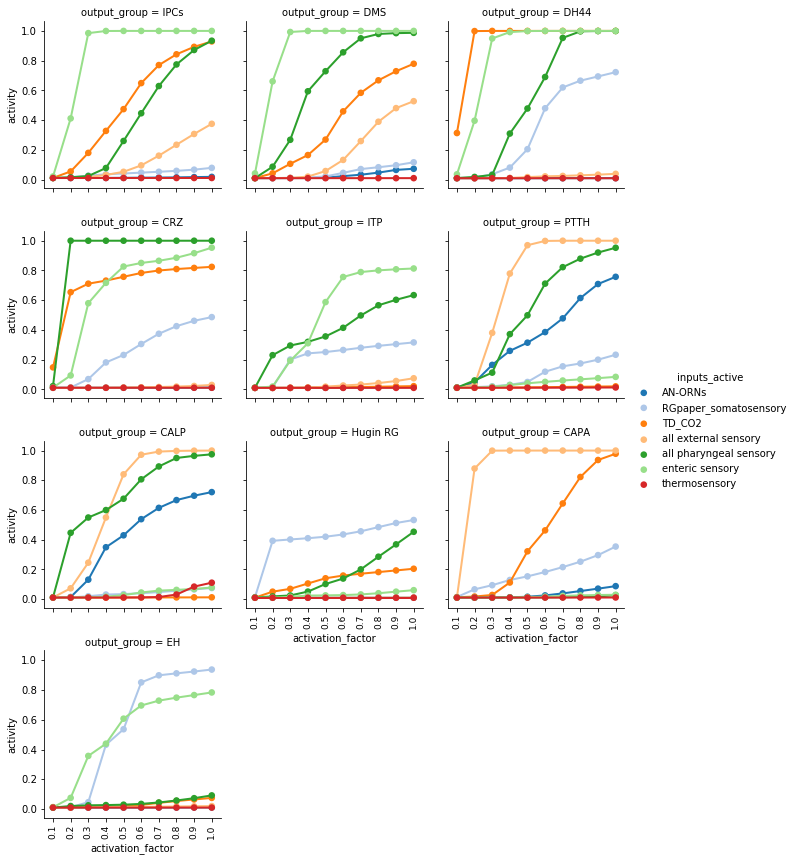

In [21]:
grid = sns.catplot(col='output_group', hue='inputs_active',
                   hue_order=sorted(activation_test_sigmoidal.inputs_active.unique()),
                   y='activity', x='activation_factor', palette='tab20', height=3, ci=None, 
                   kind='point', data=activation_test_sigmoidal, col_wrap=3, line_kws={'alpha': .5}, scale=.75, errwidth=1)

for ax in grid.axes:
    if not ax.get_xticklabels():
        continue
    ax.set_xticklabels(activation_test_sigmoidal.activation_factor.unique().round(2), size=9, rotation=90, va='top')
    #plt.savefig("ANN_0.1activation_sigmoid_050619.svg")

Couple remarks on above figure:
1. Because of the default sigmoidal activation function, even weak inputs have a strong impact on the outputs. We could ameliorated this by tuning the activation function or just normalising the activity.
2. There are only very few cases where the ranking changes upon increasing input activation (see for example SCACp and TD_CO2 for Hugin RG)

Let's plot this as heatmaps

In [22]:
# First generate matrices for each connection type
act_hm = {}
for a in activation_test_sigmoidal.activation_factor.unique():
    # Subset to this connectivity
    this_a = activation_test_sigmoidal[activation_test_sigmoidal.activation_factor==a]
    # Groupby inputs active + output group and get the mean activity
    this_a = this_a.groupby(['inputs_active', 'output_group']).activity.mean().reset_index(drop=False)
    # Turn into matrix
    act_hm[a] = this_a.pivot(index='inputs_active', columns='output_group', values='activity')    

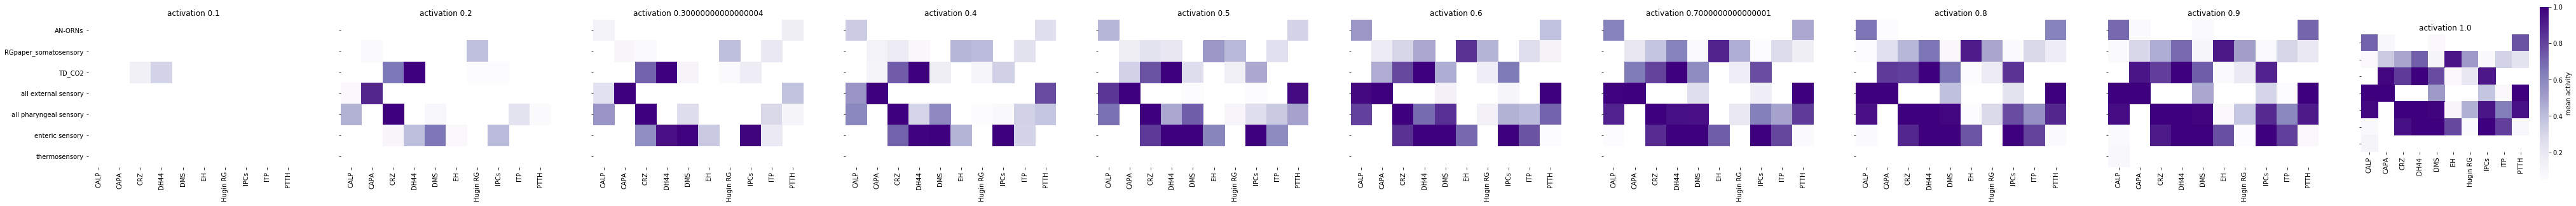

In [23]:
# Plot
fig, axes = plt.subplots(1, len(act_hm), figsize=(7*len(act_hm), 5), sharey=True)
for i, c in enumerate(activation_test_sigmoidal.activation_factor.unique()):
    m = act_hm[c]
    ax = sns.heatmap(m, ax=axes[i], vmin=.05, vmax=1, cmap='Purples', square=True, cbar=i==len(axes)-1, cbar_kws={'label': 'mean activity'}, mask=m < .05)
    ax.set_title(f'activation {c}')
    ax.set_xlabel('')
    ax.set_ylabel('')

### Let's run the same thing but with a **relu** activation function.

Note that we are tweaking the `resp_max` parameter of the relu function here because we would otherwise not get a lot of response.

Let's test the effect of different types of connections:

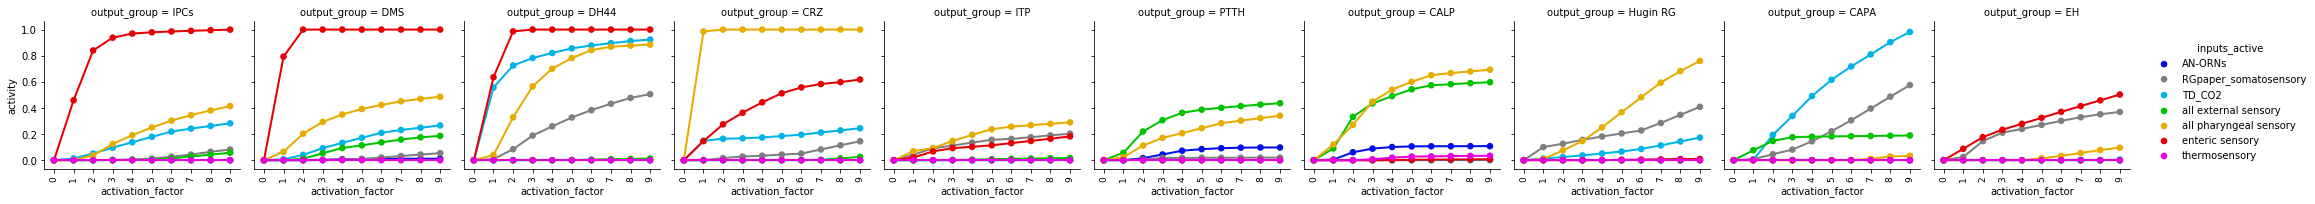

In [24]:
activation_test_relu = test_activation(nn, ingroups, outgroups, activation=np.arange(0, 10, 1), act_func=ANN.relu, resp_max=.5)
colors=['#0010E7', '#7F7F7F', '#00B4E7', '#01C300', '#E7AC00', '#E70003', '#E702DD']
sns.set_palette(sns.color_palette(colors))
grid = sns.catplot(col='output_group', hue='inputs_active',
                   hue_order=sorted(activation_test_relu.inputs_active.unique()),
                   y='activity', x='activation_factor', palette=colors, height=3, ci=None, 
                   kind='point', data=activation_test_relu, col_wrap=10, line_kws={'alpha': .5}, scale=.75, errwidth=1)

for ax in grid.axes:
    if not ax.get_xticklabels():
        continue
    ax.set_xticklabels(activation_test_relu.activation_factor.unique().round(2), size=9, rotation=90, va='top')

plt.savefig('FFN_relu_only_indirect_50-50_RGPNs_070120_intersens.svg')

In [25]:
# First generate matrices for each connection type
act_hm = {}
for a in activation_test_relu.activation_factor.unique():
    # Subset to this connectivity
    this_a = activation_test_relu[activation_test_relu.activation_factor==a]
    # Groupby inputs active + output group and get the mean activity
    this_a = this_a.groupby(['inputs_active', 'output_group']).activity.mean().reset_index(drop=False)
    # Turn into matrix
    act_hm[a] = this_a.pivot(index='inputs_active', columns='output_group', values='activity')  

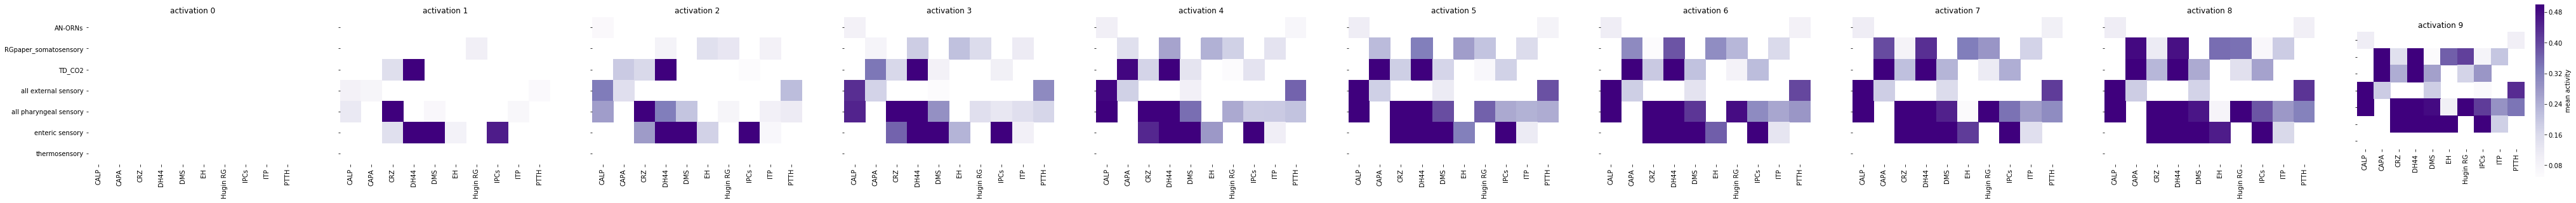

In [26]:
# Plot
fig, axes = plt.subplots(1, len(act_hm), figsize=(7*len(act_hm), 5), sharey=True)
for i, c in enumerate(activation_test_relu.activation_factor.unique()):
    m = act_hm[c]
    ax = sns.heatmap(m, ax=axes[i], vmin=.05, vmax=0.5, cmap='Purples', square=True, cbar=i==len(axes)-1, cbar_kws={'label': 'mean activity'}, mask=m < .05)
    ax.set_title(f'activation {c}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
#plt.savefig('FFN_reluheatmap_different activations_151019.svg')

In [27]:
def test_connections(nn, ingroups, outgroups, activation=4, **kwargs):
    """ Test the effect of sequentially adding connections to the simulation.
    
    Parameters
    ----------
    nn :         ANN
                 The artificial neural network to test.
    ingroups :   dict
                 Map of input group -> skeleton IDs: {'inputs1': [12345, 67890], 'inputs2': [...]}
    outgroups :  dict
                 Map of outputs group -> skeleton IDs: {'outputs1': [12345, 67890], 'outputs2': [...]}
    activation : float (0-1), optional
                 Activation factor used.
    kwargs
                 Keyword arguments passed to ANN.simulate()
                
    Returns
    -------
    pd.DataFrame
    """
    
    data = []
    
    settings = {
                'direct\nonly': {'inp_out':True, 'int_out':False, 'int_int':False, 'inp_inp':False}, 
                'indirect': {'inp_out':False, 'int_out':True, 'int_int':False, 'inp_inp':False},
                'direct\n+indirect': {'inp_out':True, 'int_out':True, 'int_int':False, 'inp_inp':False},
                'direct\n+indirect\n+inter-inter': {'inp_out':True, 'int_out':True, 'int_int':True, 'inp_inp':True},
                'indirect\n+inter-inter': {'inp_out':False, 'int_out':True, 'int_int':True, 'inp_inp':False},
                
               }

    for iname, iskids in ingroups.items():
        input_activity = pd.Series(np.zeros(len(nn.inputs)), index=nn.inputs)
        input_activity.loc[iskids] = activation
        
        # Run all settings
        for s in settings:
            kwargs.update(settings[s])
            res = nn.simulate(input_activity,act_func = ANN.relu, **kwargs)

            # Read results
            for oname, oskids in outgroups.items():
                data += [[iname, s, oname, o, res.loc[o]] for o in oskids]
    
    return pd.DataFrame(data, columns=['inputs_active', 'connectivity', 'output_group', 'skid', 'activity'])

In [28]:
connection_test = test_connections(nn, ingroups, outgroups)
connection_test.head()

,inputs_active,connectivity,output_group,skid,activity
0,enteric sensory,direct\nonly,IPCs,4506509,0.670330
1,enteric sensory,direct\nonly,IPCs,3281684,1.000000
2,enteric sensory,direct\nonly,IPCs,13535380,0.638554
3,enteric sensory,direct\nonly,IPCs,12634154,1.000000
4,enteric sensory,direct\nonly,IPCs,2852273,0.638554


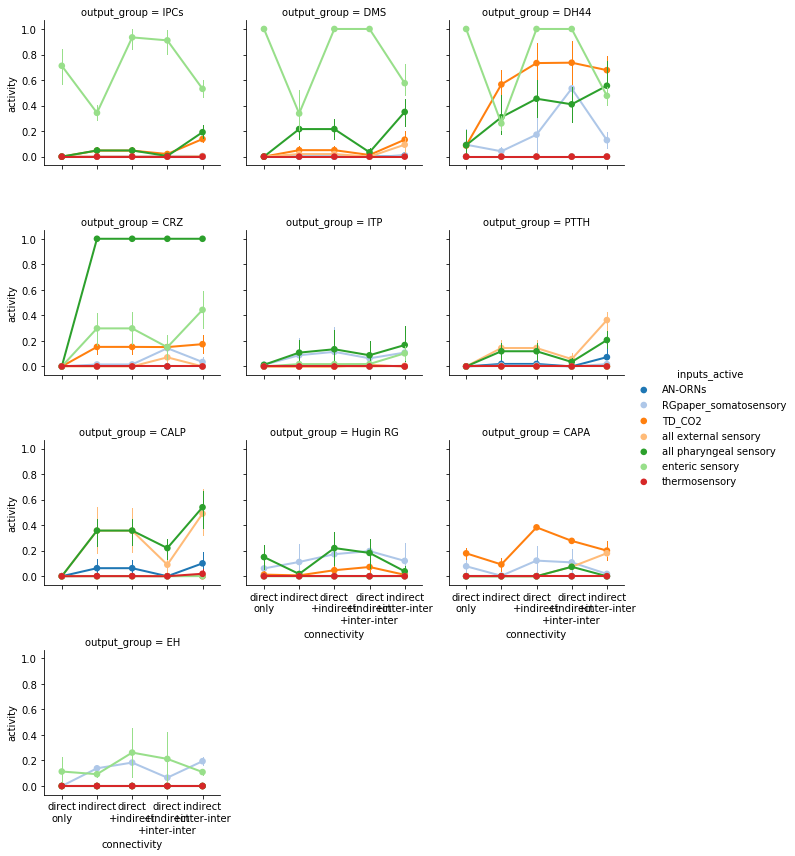

In [29]:
ax = sns.catplot(col='output_group', hue='inputs_active',
                 hue_order=sorted(connection_test.inputs_active.unique()),
                 y='activity', x='connectivity', palette='tab20', height=3,
                 kind='point', data=connection_test, col_wrap=3, line_kws={'alpha': .5}, scale=.75, errwidth=1)

Let's plot a heatmap of the above

In [30]:
# First generate matrices for each connection type
cn_hm = {}
for c in connection_test.connectivity.unique():
    # Subset to this connectivity
    this_c = connection_test[connection_test.connectivity==c]
    # Groupby inputs active + output group and get the mean activity
    this_c = this_c.groupby(['inputs_active', 'output_group']).activity.mean().reset_index(drop=False)
    # Turn into matrix
    cn_hm[c] = this_c.pivot(index='inputs_active', columns='output_group', values='activity')    

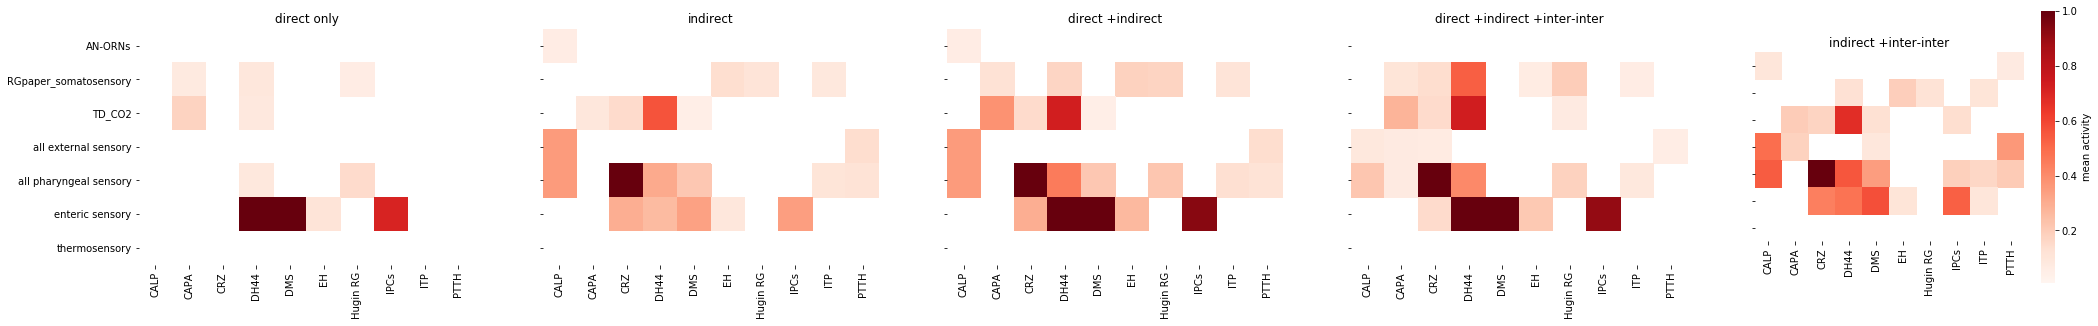

In [31]:
# Plot
fig, axes = plt.subplots(1, len(cn_hm), figsize=(7*len(cn_hm), 5), sharey=True)
for i, c in enumerate(connection_test.connectivity.unique()):
    m = cn_hm[c]
    ax = sns.heatmap(m, ax=axes[i], vmin=.01, vmax=1, cmap='Reds', square=True, cbar=i==len(axes)-1, cbar_kws={'label': 'mean activity'}, mask=m < .05)
    ax.set_title(c.replace('\n', ' '))
    ax.set_xlabel('')
    ax.set_ylabel('')
    
plt.savefig('FFN_relu_50-50_connection types_240320.svg')

#### Last but not least
Let's attempt to make some of the local neurons inhibitory.

We will do this with full connectivity (excluding `input-input`) and activate single input groups.

INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Found 26 neurons matching the search parameters (pymaid)


Neurons with inverted weights: [11687553, 5614978, 3436420, 9935752, 16018440, 16774287, 7136254, 4595609, 9787933, 3189407, 6445994, 11512247, 3443129, 16575803, 8699844, 16018123, 9455820, 19912140, 2147157, 19120853, 3728746, 16988779, 6802553, 3801211, 19040382]


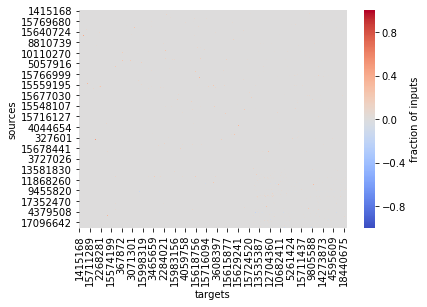

In [35]:
# Make a copy of the original network
nn2 = nn.copy()

# Replace with more meaningful annotation
to_invert = pymaid.find_neurons(annotations='CO2_interneurons')

# Subset to those neurons that are actually in the adjacency matrix
to_invert_skids = list(set(nn2.adj.index) & set(to_invert.skeleton_id.astype(int)))

# Invert weights of those neurons
nn2.invert_weights(to_invert_skids)

# Let's see which ones got inverted
print('Neurons with inverted weights:', to_invert_skids)

ax = sns.heatmap(nn2.adj, cmap='coolwarm', cbar_kws={'label': 'fraction of inputs'})

Run one the activation test with relu function:

In [36]:
# Run the test 
activation_test_relu_inhibition = test_activation(nn2, ingroups, outgroups, activation=np.arange(0.1, 1.1, .1), act_func=ANN.relu, resp_max=.5)

# Combine with our previous results - make sure parameters are the same!
activation_test_relu_inhibition['state'] = 'with_inhibition'
activation_test_relu['state'] = 'excitation_only'

activation_test_combined = pd.concat([activation_test_relu_inhibition, activation_test_relu])

We'll plot only results for `activation_factor=1`:

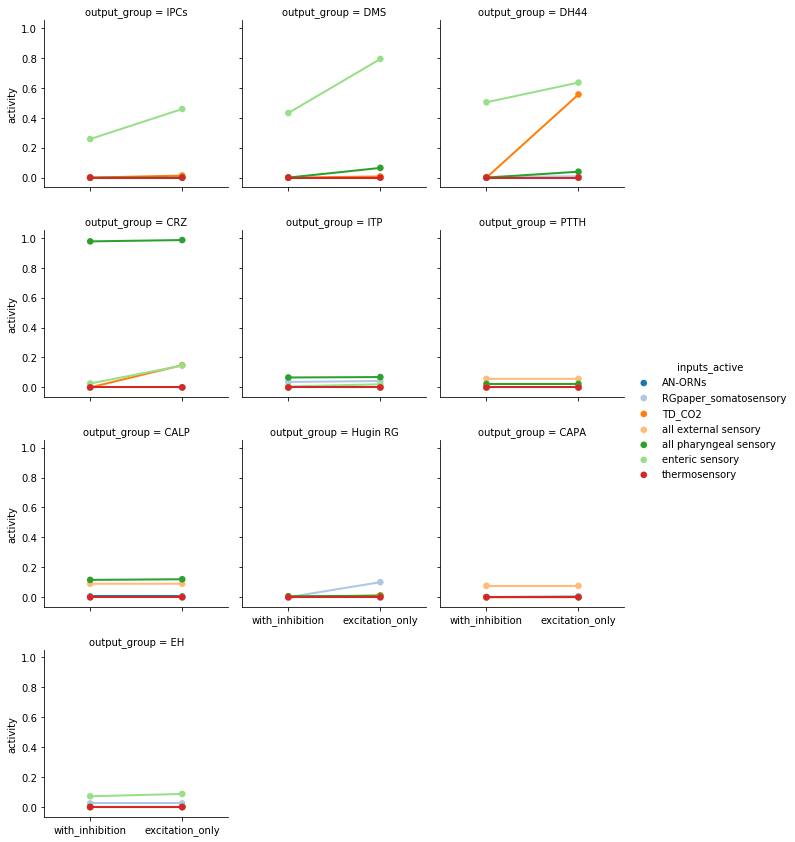

In [37]:
grid = sns.catplot(col='output_group', hue='inputs_active', style='state',
                   hue_order=sorted(activation_test_combined.inputs_active.unique()),
                   y='activity', x='state', palette='tab20', height=3, ci=None, 
                   kind='point', col_wrap=3, line_kws={'alpha': .5}, scale=.75, errwidth=1,
                   data=activation_test_combined[activation_test_combined.activation_factor == 1], )

for ax in grid.axes:
    if not ax.get_xticklabels():
        continue
    ax.set_xlabel('')    